## PHY 411: Final Project
### Jeremy Kazimer
### jdkazime@buffalo.edu

#### _Import Statements_

To begin this portion of the project, we import the Python file I created which contains the network class and its methods.  We also import the file which contains the entropy methods:

In [2]:
import sys
sys.path.insert(1, 'utility/')

from generate_network import *
from calculate_entropy import *

We'll also want to import `numpy` and `matplotlib`:

In [3]:
from numpy import concatenate, linspace, logspace, zeros
from matplotlib import pyplot as plt

Now, the analysis can begin:

#### _Generate Network_

Since edge rankings are best defined for community structure, we can opt to form an SBM with the conditions $N = 100$, $k = 2$, $p_{in} = 0.3$, and $p_{out} = 0.05$:

In [4]:
N = 100
k = 2
p_in = 0.3
p_out = 0.05

In [5]:
G = SBM(N, p_in, p_out, k = k)

In [6]:
edge_colors, locs = G.get_edge_colors('grey', 'red')

And, of course, the `networkx` plot:

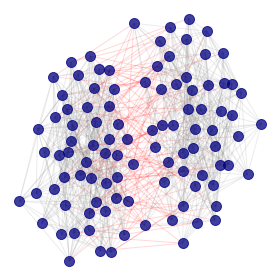

In [7]:
fig, ax = G.plot_networkx(edge_color = edge_colors)

#### _Ranking this Graph_

Now, we can calculate the rankings on a static time domain.  That is to say, there is no rewiring such that we treat each instance of rewiring as a frame of motion.  So, basically, the time state.  We'll start with $\beta = 1$:

In [8]:
Hs, sorts, ranks = edge_rankings(G.copy_graph())

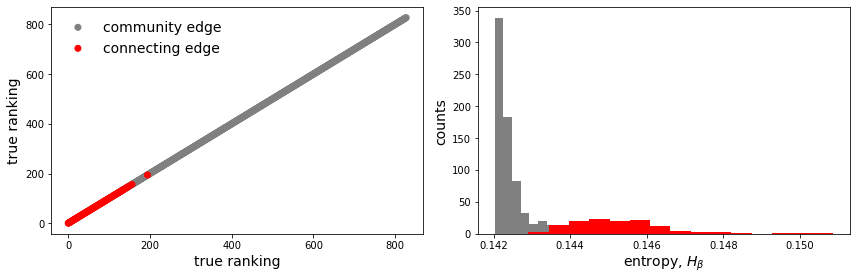

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))

axs[0].scatter(ranks[locs], ranks[locs], c = edge_colors[locs].flatten(), label = 'community edge')
axs[0].scatter(ranks[~locs], ranks[~locs], c = edge_colors[~locs].flatten(), label = 'connecting edge')
axs[0].legend(loc = 'upper left', fontsize = 14, frameon = False)

axs[0].set_xlabel('true ranking', fontsize = 14)
axs[0].set_ylabel('true ranking', fontsize = 14)


axs[1].hist(Hs[locs], 15, color = edge_colors[locs][0])
axs[1].hist(Hs[~locs], 15, color = edge_colors[~locs][0])

axs[1].set_ylabel('counts', fontsize = 14)
axs[1].set_xlabel(r'entropy, $H_\beta$', fontsize = 14)

fig.tight_layout()
fig.savefig('figures/rankings_and_entropy.png')

Here, we plot the rankings against themselves to highlight which edges are most important.  Here, it is clear that the connecting edges are most important.  And from the figure on the right, this is because their removal generates the most entropy.  Like, there is a clear disconnect.  

However, the current metric is kind of silly.  We can devise something better.  How about of the top 10% of edges, how many of which are the connecting edges?

In [10]:
print(top_ranked(sorts, locs))

92.6829268292683


So, pretty good.  Now, we can ditch the above plots in favor of this metric.  Of course, it'll require some tinkering, but we can try that now...

In [11]:
cutoffs = linspace(1, 100, 101)/100
percents = zeros(cutoffs.shape[0])

for idx, cutoff in enumerate(cutoffs):
    
    percents[idx] = top_ranked(sorts, locs, cutoff = cutoff)

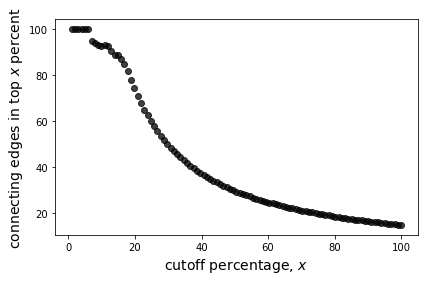

In [12]:
fig, ax = plt.subplots(1, 1)

ax.scatter(cutoffs*100, percents, c = 'k', alpha = 0.75)

ax.set_ylabel('connecting edges in top $x$ percent', fontsize = 14)
ax.set_xlabel('cutoff percentage, $x$', fontsize = 14)

fig.tight_layout()

Makes sense.  It eventually converges to being probably the proportion of total connecting edges to total community edges.  We can check this:

In [13]:
print(G.outside_edges.shape[0]/G.inside_edges.shape[0] * 100 - percents[-1])

2.5917360468701833


So, it's not quite, but it's close.  Not a big deal, since we'll never look at the end cases since that defeats the purpose of this experiment.

For fairness, for the next experiment, we'll use the proportion of connecting edges to community edges, as some standard value.

#### _Rankings by Time-Scale Parameter_

So, what if our time-scale parameter, $\beta$, changes? Then what? Well, we can repeat the above code to observe this:

In [14]:
betas = linspace(1e-5, 1e1, 26)
beta_percs = zeros(betas.shape[0])
cutoff = G.outside_edges.shape[0]/G.inside_edges.shape[0]

for idx, beta in enumerate(betas):
    _, sorts, _ = edge_rankings(G.copy_graph(), beta = beta)
    
    beta_percs[idx] = top_ranked(sorts, locs, cutoff = cutoff)

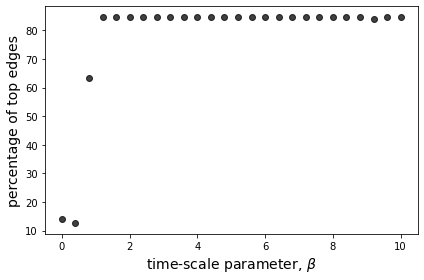

In [15]:
fig, ax = plt.subplots(1, 1)

ax.scatter(betas, beta_percs, c = 'k', alpha = 0.75)

ax.set_xlabel(r'time-scale parameter, $\beta$', fontsize = 14)
ax.set_ylabel('percentage of top edges', fontsize = 14)

fig.tight_layout()

Well, this isn't very interesting! So, we should separate these into two plots.  One from the left side approaching $1$, and the other moving away to the right from $1$.  It appears that beyond $\beta = 1$, the system is rigid.

In [16]:
betas = concatenate((linspace(1e-5, 1e0, 13), linspace(1e0, 1e1, 13)))
beta_percs = zeros(betas.shape[0])
cutoff = G.outside_edges.shape[0]/G.inside_edges.shape[0]

for idx, beta in enumerate(betas):
    _, sorts, _ = edge_rankings(G.copy_graph(), beta = beta)
    
    beta_percs[idx] = top_ranked(sorts, locs, cutoff = cutoff)

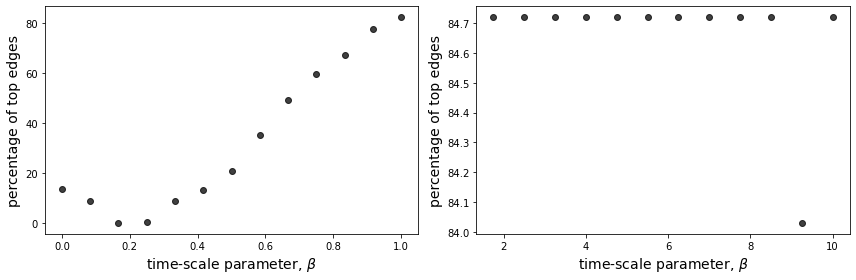

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
n = betas.shape[0]//2

axs[0].scatter(betas[:n], beta_percs[:n], c = 'k', alpha = 0.75)

axs[0].set_xlabel(r'time-scale parameter, $\beta$', fontsize = 14)
axs[0].set_ylabel('percentage of top edges', fontsize = 14)

axs[1].scatter(betas[n + 1:], beta_percs[n + 1:], c = 'k', alpha = 0.75)

axs[1].set_xlabel(r'time-scale parameter, $\beta$', fontsize = 14)
axs[1].set_ylabel('percentage of top edges', fontsize = 14)

fig.tight_layout()
fig.savefig('figures/topranked_vs_beta.png')

Yeah, it's rigid.  So, anything above $\beta = 1$ we don't really want to use.  The system quickly escalates to its terminal value.  As such, any experiment forward will probasbly just use $\beta = 1$, since it's the most unassuming parameter - it doesn't change the weight of the eigenvalues by any means.